# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [4]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum
from collections import defaultdict
import pyspark.sql.functions as func

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
# create a Spark session
sp = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load dataset

In [6]:
df = sp.read.json('mini_sparkify_event_data.json')

### Check for duplicates in the Data Frame

In [7]:
df.count()

286500

In [8]:
df.dropDuplicates().count()

286500

Since the count is the same before and after dropping duplicate, it implies there is no duplicate in the Data Frame.

### Check for missing values

Two ways of checking missing values are presented.

First, by looking at descriptive statistics of the data frame. The 'count' statistics will filter out null values, leave us only the values that is not null. Compare that number to the total count, we know how many values are present for each columns, and hence how many values are missing in each column.

Now take a look at some sample rows of data.

In [9]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [10]:
"""
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|              278154|           286500|              228108|            286500|              286500|              278154|           286500|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|249.1171819778458|  null|             null|  null|   null|1.535358834084427...|1041.526554973822|            Infinity|210.05459685863875|1.540956889810483...|                null|59682.02278593872|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|99.23517921058361|  null|             null|  null|   null| 3.291321616327586E9|726.7762634630741|                 NaN| 31.50507848842214|1.5075439608226302E9|                null|109091.9499991047|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|          0.78322|  free|       Albany, OR|   GET|  About|       1521380675000|                1|ÃÂg ÃÂtti Gr...|               200|       1538352117000|"Mozilla/5.0 (Mac...|                 |
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|       3024.66567|  paid|Winston-Salem, NC|   PUT|Upgrade|       1543247354000|             2474|ÃÂau hafa slopp...|               404|       1543799476000|Mozilla/5.0 (comp...|               99|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
""";

Any column whose count is not 286500, has some missing values. For example, 'artist', 'gender' have missing values. 'auth' does not have missing values.

Second way to look for missing values is to use sql query function, specicially, the `isNull` function that will tell us whether a particular cell's value is null. Convert the True or False value into integer and get the sum, and will give us numbers of missing values directly.

In [11]:
def print_missing_values():
    missing_values_dict = df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).first().asDict()
    for k, v in missing_values_dict.items():
        print('{} is missing {} values.'.format(k, v))
    return missing_values_dict

missing_values_dict = print_missing_values()

artist is missing 58392 values.
auth is missing 0 values.
firstName is missing 8346 values.
gender is missing 8346 values.
itemInSession is missing 0 values.
lastName is missing 8346 values.
length is missing 58392 values.
level is missing 0 values.
location is missing 8346 values.
method is missing 0 values.
page is missing 0 values.
registration is missing 8346 values.
sessionId is missing 0 values.
song is missing 58392 values.
status is missing 0 values.
ts is missing 0 values.
userAgent is missing 8346 values.
userId is missing 0 values.


Observe that missing values appear to have grouping effect, e.g., several coumns likely all missed values at the same time. As their missing values counts are exactly the same. We can group them together to provide us more insight.

In [12]:
def print_missing_values_group(missing_values_dict):
    value_to_key = defaultdict(list)
    for k, v in missing_values_dict.items():
        value_to_key[v].append(k)

    for v, ks in value_to_key.items():
        print('{} missing values: {}'.format(v, ks))

print_missing_values_group(missing_values_dict)

58392 missing values: ['artist', 'length', 'song']
0 missing values: ['auth', 'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts', 'userId']
8346 missing values: ['firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']


We found there are three types of columns in terms of missing values:
1. The group does not miss any value. This groups includes 'userId', sessionId'
2. The group that miss name info, likely about the users.
3. The group that miss info about the song.

At this moment, we do not know whether missing these values have a material effect on the features we are looking for or not. Hence we decided not to drop of any missing values. Leave the decision to later when we have more understandings on the data.


In [13]:
# drop all null
#df.na.drop()
#df.na.drop(['firstName'])

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [15]:
'''
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows
''';

Through offline grep operation, 'Cancellation Confirmation' is one type of pages. We filter some page with type of 'Cancellation Confirmation' as below.

In [16]:
df.filter("page = 'Cancellation Confirmation'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [17]:
df.filter("page = 'Cancellation Confirmation'").count()

52

There are total of 52 'Cancellation Confirmation' page in this mini dataset.

In [18]:
df.filter("page = 'Downgrade'").count()

2055

There are total of 2055 'Downgrade' page in this mini dataset.

Observing the sample data, the dataset appears to be browsing history of users. In other words, the dataset contains activities of each user interacting with the software.

Inituitively, it makes sense to take each user as an unit for researching.

Look at a few sample users and manually observe their behavior.

In [19]:
df.filter("userId = 9").show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|   NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|              Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...

This user at id 9 have many activities. Let's choose users with less activities for easier analysis since we are looking for general observation to explore the data, not deep analysis of each user at this moment.

Sort the users by number of records associated with the users.

In [20]:
df.groupBy("userId").agg(func.count(func.lit(1)).alias("Num Of Records")).sort("Num Of Records").show(10)

+------+--------------+
|userId|Num Of Records|
+------+--------------+
|   135|             6|
|   156|             6|
|   125|            11|
|100011|            23|
|300003|            35|
|100024|            36|
|    22|            40|
|   133|            44|
|100006|            44|
|    90|            45|
+------+--------------+
only showing top 10 rows



Pick user 125 and user 100006 as sample for observation.

In [21]:
df.filter("userId = 125").show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|    paranoid android|   200|1539317144000|"Mozilla/5.0 (Mac...|   125|
|The Notorious B.I.G.|Logged In|    Mason|     M|            1|    Hart|230.0338

In [22]:
'''
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|    paranoid android|   200|1539317144000|"Mozilla/5.0 (Mac...|   125|
|The Notorious B.I.G.|Logged In|    Mason|     M|            1|    Hart|230.03383| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|Hypnotize(Album V...|   200|1539317481000|"Mozilla/5.0 (Mac...|   125|
|           Betty Boo|Logged In|    Mason|     M|            2|    Hart| 203.2322| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|       I'm On My Way|   200|1539317711000|"Mozilla/5.0 (Mac...|   125|
|          Nickelback|Logged In|    Mason|     M|            3|    Hart|210.83383| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|Leader Of Men (Al...|   200|1539317914000|"Mozilla/5.0 (Mac...|   125|
| Ready For The World|Logged In|    Mason|     M|            4|    Hart|391.26159| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|       Love You Down|   200|1539318124000|"Mozilla/5.0 (Mac...|   125|
|   We Are The Fallen|Logged In|    Mason|     M|            5|    Hart|213.60281| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|Don't Leave Me Be...|   200|1539318515000|"Mozilla/5.0 (Mac...|   125|
|      Robert Johnson|Logged In|    Mason|     M|            6|    Hart|178.41587| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|     They're Red Hot|   200|1539318728000|"Mozilla/5.0 (Mac...|   125|
|              Bonobo|Logged In|    Mason|     M|            7|    Hart|323.81342| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|                Kota|   200|1539318906000|"Mozilla/5.0 (Mac...|   125|
|                null|Logged In|    Mason|     M|            8|    Hart|     null| free|Corpus Christi, TX|   GET|         Roll Advert|1533157139000|      174|                null|   200|1539318917000|"Mozilla/5.0 (Mac...|   125|
|                null|Logged In|    Mason|     M|            9|    Hart|     null| free|Corpus Christi, TX|   PUT|              Cancel|1533157139000|      174|                null|   307|1539318918000|"Mozilla/5.0 (Mac...|   125|
|                null|Cancelled|    Mason|     M|           10|    Hart|     null| free|Corpus Christi, TX|   GET|Cancellation Conf...|1533157139000|      174|                null|   200|1539318918000|"Mozilla/5.0 (Mac...|   125|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
''';

In [23]:
df.filter("userId = 100006").show(44)

+--------------------+---------+---------+------+-------------+--------+---------+-----+---------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level| location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+---------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|                null|Logged In|    Leyla|     F|            0|  Barnes|     null| free|Flint, MI|   GET|                Home|1537964483000|        6|                null|   200|1538747464000|"Mozilla/5.0 (Win...|100006|
|Johnny Kidd & The...|Logged In|    Leyla|     F|            1|  Barnes| 140.9824| free|Flint, MI|   PUT|           

In [24]:
'''
+--------------------+---------+---------+------+-------------+--------+---------+-----+---------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level| location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+---------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|                null|Logged In|    Leyla|     F|            0|  Barnes|     null| free|Flint, MI|   GET|                Home|1537964483000|        6|                null|   200|1538747464000|"Mozilla/5.0 (Win...|100006|
|Johnny Kidd & The...|Logged In|    Leyla|     F|            1|  Barnes| 140.9824| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|    Shakin' All Over|   200|1538747466000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|            2|  Barnes|     null| free|Flint, MI|   GET|         Roll Advert|1537964483000|        6|                null|   200|1538747474000|"Mozilla/5.0 (Win...|100006|
| Theory Of A Deadman|Logged In|    Leyla|     F|            3|  Barnes|251.55873| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|    So Happy [Clean]|   200|1538747606000|"Mozilla/5.0 (Win...|100006|
| Kanye West / T-Pain|Logged In|    Leyla|     F|            4|  Barnes|207.04608| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|           Good Life|   200|1538747857000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|            5|  Barnes|     null| free|Flint, MI|   PUT|         Thumbs Down|1537964483000|        6|                null|   307|1538747858000|"Mozilla/5.0 (Win...|100006|
|           Aerosmith|Logged In|    Leyla|     F|            6|  Barnes|  294.922| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|            Dream On|   200|1538748064000|"Mozilla/5.0 (Win...|100006|
|         Kurt Elling|Logged In|    Leyla|     F|            7|  Barnes|   38.922| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|    Acknowledgements|   200|1538748358000|"Mozilla/5.0 (Win...|100006|
|           Cat Power|Logged In|    Leyla|     F|            8|  Barnes|209.76281| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|              He War|   200|1538748396000|"Mozilla/5.0 (Win...|100006|
|      Ibrahim Ferrer|Logged In|    Leyla|     F|            9|  Barnes|304.48281| free|Flint, MI|   PUT|            NextSong|1537964483000|        6| MamÃÂ­ Me GustÃÂ³|   200|1538748605000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           10|  Barnes|     null| free|Flint, MI|   PUT|     Add to Playlist|1537964483000|        6|                null|   200|1538748611000|"Mozilla/5.0 (Win...|100006|
|           Van Halen|Logged In|    Leyla|     F|           11|  Barnes|277.08036| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|              Get Up|   200|1538748909000|"Mozilla/5.0 (Win...|100006|
|          John Mayer|Logged In|    Leyla|     F|           12|  Barnes|269.71383| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|  Heartbreak Warfare|   200|1538749186000|"Mozilla/5.0 (Win...|100006|
|the bird and the bee|Logged In|    Leyla|     F|           13|  Barnes|206.57587| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|           The Races|   200|1538749455000|"Mozilla/5.0 (Win...|100006|
|       Regi & Danzel|Logged In|    Leyla|     F|           14|  Barnes|258.40281| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|What Is Life (Reg...|   200|1538749661000|"Mozilla/5.0 (Win...|100006|
|      Secret Service|Logged In|    Leyla|     F|           15|  Barnes|218.25261| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|  Flash In The Night|   200|1538749919000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           16|  Barnes|     null| free|Flint, MI|   GET|         Roll Advert|1537964483000|        6|                null|   200|1538749920000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           17|  Barnes|     null| free|Flint, MI|   GET|         Roll Advert|1537964483000|        6|                null|   200|1538749922000|"Mozilla/5.0 (Win...|100006|
|Bill Wells & Mahe...|Logged In|    Leyla|     F|           18|  Barnes|131.44771| free|Flint, MI|   PUT|            NextSong|1537964483000|        6| Banned Announcement|   200|1538750137000|"Mozilla/5.0 (Win...|100006|
|               Cabas|Logged In|    Leyla|     F|           19|  Barnes|223.92118| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|    La Cadena De Oro|   200|1538750268000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           20|  Barnes|     null| free|Flint, MI|   PUT|           Thumbs Up|1537964483000|        6|                null|   307|1538750269000|"Mozilla/5.0 (Win...|100006|
|           Fever Ray|Logged In|    Leyla|     F|           21|  Barnes|342.93506| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|               Seven|   200|1538750491000|"Mozilla/5.0 (Win...|100006|
|       Ismael Rivera|Logged In|    Leyla|     F|           22|  Barnes|249.46893| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|               Suave|   200|1538750833000|"Mozilla/5.0 (Win...|100006|
|      Pugh Rogefeldt|Logged In|    Leyla|     F|           23|  Barnes|186.22649| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|           Stockholm|   200|1538751082000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           24|  Barnes|     null| free|Flint, MI|   PUT|          Add Friend|1537964483000|        6|                null|   307|1538751083000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           25|  Barnes|     null| free|Flint, MI|   PUT|          Add Friend|1537964483000|        6|                null|   307|1538751084000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           26|  Barnes|     null| free|Flint, MI|   PUT|          Add Friend|1537964483000|        6|                null|   307|1538751085000|"Mozilla/5.0 (Win...|100006|
|          Emre Aydin|Logged In|    Leyla|     F|           27|  Barnes|276.97587| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|Belki Bir Gun Ozl...|   200|1538751268000|"Mozilla/5.0 (Win...|100006|
|      Homesick James|Logged In|    Leyla|     F|           28|  Barnes|199.65342| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|Working With Home...|   200|1538751544000|"Mozilla/5.0 (Win...|100006|
|          Lazlo Bane|Logged In|    Leyla|     F|           29|  Barnes|218.48771| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|            Superman|   200|1538751743000|"Mozilla/5.0 (Win...|100006|
|       Cocteau Twins|Logged In|    Leyla|     F|           30|  Barnes| 220.1073| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|      Millimillenary|   200|1538751961000|"Mozilla/5.0 (Win...|100006|
|                Beck|Logged In|    Leyla|     F|           31|  Barnes|202.31791| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|               E-Pro|   200|1538752181000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           32|  Barnes|     null| free|Flint, MI|   PUT|           Thumbs Up|1537964483000|        6|                null|   307|1538752182000|"Mozilla/5.0 (Win...|100006|
|Christina Aguiler...|Logged In|    Leyla|     F|           33|  Barnes|264.93342| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|      Lady Marmalade|   200|1538752383000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           34|  Barnes|     null| free|Flint, MI|   PUT|         Thumbs Down|1537964483000|        6|                null|   307|1538752384000|"Mozilla/5.0 (Win...|100006|
|                Maps|Logged In|    Leyla|     F|           35|  Barnes|203.78077| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|You Don't Know He...|   200|1538752647000|"Mozilla/5.0 (Win...|100006|
|The Unfinished Sy...|Logged In|    Leyla|     F|           36|  Barnes|212.00934| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|         Ceasie fire|   200|1538752850000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           37|  Barnes|     null| free|Flint, MI|   PUT|              Logout|1537964483000|        6|                null|   307|1538752851000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           40|  Barnes|     null| free|Flint, MI|   GET|                Home|1537964483000|        6|                null|   200|1538752865000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           41|  Barnes|     null| free|Flint, MI|   PUT|          Add Friend|1537964483000|        6|                null|   307|1538752866000|"Mozilla/5.0 (Win...|100006|
|          Arch Enemy|Logged In|    Leyla|     F|           42|  Barnes|244.92363| free|Flint, MI|   PUT|            NextSong|1537964483000|        6|          Silverwing|   200|1538753062000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           43|  Barnes|     null| free|Flint, MI|   GET|            Settings|1537964483000|        6|                null|   200|1538753066000|"Mozilla/5.0 (Win...|100006|
|                null|Logged In|    Leyla|     F|           44|  Barnes|     null| free|Flint, MI|   PUT|              Cancel|1537964483000|        6|                null|   307|1538753067000|"Mozilla/5.0 (Win...|100006|
|                null|Cancelled|    Leyla|     F|           45|  Barnes|     null| free|Flint, MI|   GET|Cancellation Conf...|1537964483000|        6|                null|   200|1538753070000|"Mozilla/5.0 (Win...|100006|
+--------------------+---------+---------+------+-------------+--------+---------+-----+---------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+

''';

Now we can identity the data worth looking deeper into. The data (columns) can be splited into some groups:

1. Most of the data are repeat and should not have effect on the churn rate. For example, name of the user, should not nothing to do with churn rate.
2. Some data are also repeat, and although might has a slight effect, and should not have effect in churn rate either. For example, an user in location of Flint, MI is likely not have higher churn rate than an user in Houston, TX. When user regisrted might not but likely very small effect.
3. Song, artiest related info could be interesting. Will people listening to certain aritist will stay longer with the service?
4. Some technical related info, such as method, itemSession, are HTTP request type, session id, respectively and make no sense for them to affect churn rate.
5. 'length', which is the time user spent on that page. Obviously have effect on the retention. Users spent more time are considered more engaging, and should be loyal to the service. Combined with 'ts' timestamp, we could develop a metric like daily usage rate. Which can be a good measure of user's engagement.
6. 'page', which indicate the activity of users, could be interesting as well. This worth looking further into.



In [25]:
df.select("page").distinct().show(100)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Looking at the type of pages, it appear to have many rich functions. For example, in addition to normal song listening activities, an user can 'Add Friend', 'Thumbs Up'. These type of social activities likely increase engagement of users.

In [26]:
df.select("userId").distinct().count()

226

There are total of 226 users in this min dataset. This gives us a scope of the data.

In [27]:
df.select("status").distinct().show(100)

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [28]:
df.filter("status = 404").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           48|   Baker|  null| paid|Kingsport-Bristol...|   GET|Error|1533102330000|      249|null|   404|1538393848000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Lucero|     F|           10|    Reed|  null| free|Louisville/Jeffer...|   GET|Error|1536642109000|      139|null|   404|1538407927000|"Mozilla/5.0 (Win...|   140|
|  null|Logged In|Sebastian|     M|           38|    Wang|  null| free|         

The status is a simple HTTP status code. But will a failed page frustrate users and make them less loyal? Further looking into the status code, it appears to be a normal procedure of user's activity.

Further looking into the status, there are only 3 types. 200 is normal. 307 is redirect due to user's action on page, hence is normal as well. 404 is error and given the context, we do not know why it happened. This might nor might not be an issue without knowing further about the context. However, give that 404 is always associated with page 'Error', this info is covered by 'page' type already, making status code redundant. So we will look at page type alone to extract this info.


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features to extract

With the founding from EDA section, we decided to extract the following data, per user:
1. Number of records, e.g., the number of activities user interact with the serivce.
2. Number of actions, for each type of action as indicated by page type. For example, how many times the user perform "NextSong", "Add to Playlist", "Add Friend", and all other actions.
3. The average time spent on each action. This value exist only if the action is listening to the Song, e.g. "NextSong".
4. The averge, of total amount of time spent, each day. This is different from the time spent per action. Per action time is likely correlated to length of song, while time spent per day could be a better measure of engageness of user.
5. **The "Cancel" action cannot be used as feature!** Initially, we considered the Cancel action to be just cancel previous action. The model testing with Cancel action included as feature resulted in 100% accuracy. Hindsight, the "Cancel" does not mean user wants to cancel playing a song, but mean user wants to Cancel service, while "Cancellation Confirmation" servers as confirmation. That's why there is a 1 to 1 match of these two values.

In [29]:
df_features = df.groupBy("userId").agg(
                         func.count(func.lit(1)).alias("Num Of Records"), \
                         func.mean('length').alias("AvgLength"), \
                         #func.count(func.when(df["page"] == "Cancel", 1)).alias("Cancel"), \
                         func.count(func.when(df["page"] == "Submit Downgrade", 1)).alias("Submit Downgrade"), \
                         func.count(func.when(df["page"] == "Thumbs Down", 1)).alias("Thumbs Down"), \
                         func.count(func.when(df["page"] == "Home", 1)).alias("Home"), \
                         func.count(func.when(df["page"] == "Downgrade", 1)).alias("Downgrade"), \
                         func.count(func.when(df["page"] == "Roll Advert", 1)).alias("Roll Advert"), \
                         func.count(func.when(df["page"] == "Logout", 1)).alias("Logout"), \
                         func.count(func.when(df["page"] == "Save Settings", 1)).alias("Save Settings"), \
                         func.count(func.when(df["page"] == "Cancellation Confirmation", 1)).alias("Cancellation Confirmation"), \
                         func.count(func.when(df["page"] == "About", 1)).alias("About"), \
                         func.count(func.when(df["page"] == "Submit Registration", 1)).alias("Submit Registration"), \
                         func.count(func.when(df["page"] == "Settings", 1)).alias("Settings"), \
                         func.count(func.when(df["page"] == "Login", 1)).alias("Login"), \
                         func.count(func.when(df["page"] == "Register", 1)).alias("Register"), \
                         func.count(func.when(df["page"] == "Add to Playlist", 1)).alias("Add to Playlist"), \
                         func.count(func.when(df["page"] == "Add Friend", 1)).alias("Add Friend"), \
                         func.count(func.when(df["page"] == "NextSong", 1)).alias("NextSong"), \
                         func.count(func.when(df["page"] == "Thumbs Up", 1)).alias("Thumbs Up"), \
                         func.count(func.when(df["page"] == "Help", 1)).alias("Help"), \
                         func.count(func.when(df["page"] == "Upgrade", 1)).alias("Upgrade"), \
                         func.count(func.when(df["page"] == "Error", 1)).alias("Error"), \
                         func.count(func.when(df["page"] == "Submit Upgrade", 1)).alias("Submit Upgrade"), \
                        )

The time spent per day requires a little more processing to provide per user data on this metric.

In [30]:
df = df.withColumn('ts1000date_trunc', func.date_trunc('day', (df.ts/1000).cast("timestamp")))
daily_length_df = df.groupBy('userId', 'ts1000date_trunc').sum('length')
daily_length_df = daily_length_df.groupBy('userId').mean()
daily_length_df = daily_length_df.withColumnRenamed('avg(sum(length))', 'DailyAvgLength')
daily_length_df.show()

+------+------------------+
|userId|    DailyAvgLength|
+------+------------------+
|200002|13429.839419999995|
|100010| 9562.985335714286|
|   125|2089.1131000000005|
|   124|  31634.7528996875|
|    51| 40251.98790769231|
|     7|      4754.2608875|
|    54|23711.497318000005|
|    15|25121.452937368413|
|   155|24847.411487499998|
|   132| 23005.66208761905|
|   154|6886.6746366666675|
|100014|11283.912013333334|
|    11|        9979.37269|
|   101|34420.308820769234|
|   138|30144.110750588236|
|300017|18695.978754375006|
|    69|23838.668803333338|
|    29|26017.846985172404|
|100021|11526.635128000004|
|    42|21507.145515365853|
+------+------------------+
only showing top 20 rows



In [31]:
df_features = df_features.join(daily_length_df, df_features.userId == daily_length_df.userId).drop(daily_length_df.userId)

In [32]:
df_features.show(5)

+--------------+------------------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+------------------+
|Num Of Records|         AvgLength|Submit Downgrade|Thumbs Down|Home|Downgrade|Roll Advert|Logout|Save Settings|Cancellation Confirmation|About|Submit Registration|Settings|Login|Register|Add to Playlist|Add Friend|NextSong|Thumbs Up|Help|Upgrade|Error|Submit Upgrade|userId|    DailyAvgLength|
+--------------+------------------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+------------------+
|           381|  243.421444909091|               0|          5|  11|        0|         52|     5|            0|   

In [33]:
'''
+--------------+------------------+------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+------------------+
|Num Of Records|         AvgLength|Cancel|Submit Downgrade|Thumbs Down|Home|Downgrade|Roll Advert|Logout|Save Settings|Cancellation Confirmation|About|Submit Registration|Settings|Login|Register|Add to Playlist|Add Friend|NextSong|Thumbs Up|Help|Upgrade|Error|Submit Upgrade|userId|    DailyAvgLength|
+--------------+------------------+------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+------------------+
|           381|  243.421444909091|     0|               0|          5|  11|        0|         52|     5|            0|                        0|    1|                  0|       0|    0|       0|              7|         4|     275|       17|   2|      2|    0|             0|100010| 9562.985335714286|
|           474|242.91699209302305|     0|               0|          6|  20|        5|          7|     5|            0|                        0|    3|                  0|       3|    0|       0|              8|         4|     387|       21|   2|      2|    0|             1|200002|13429.839419999995|
|            11|261.13913750000006|     1|               0|          0|   0|        0|          1|     0|            0|                        1|    0|                  0|       0|    0|       0|              0|         0|       8|        0|   0|      0|    0|             0|   125|2089.1131000000005|
|          4825|248.17653659965674|     0|               0|         41| 176|       41|          4|    59|            6|                        0|    7|                  0|      20|    0|       0|            118|        74|    4079|      171|  23|      0|    6|             0|   124|  31634.7528996875|
|          2464|247.88055082899118|     1|               0|         21|  75|       23|          0|    24|            1|                        1|    2|                  0|      12|    0|       0|             52|        28|    2111|      100|  12|      0|    1|             0|    51| 40251.98790769231|
+--------------+------------------+------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+------------------+
only showing top 5 rows
''';

A quick check on the final data. For exampe, each user should cancel either once, or never.

In [34]:
df_features.select("Cancellation Confirmation").distinct().show(100)

+-------------------------+
|Cancellation Confirmation|
+-------------------------+
|                        0|
|                        1|
+-------------------------+



Check for resulting features data frame's duplicate and missing values status.

In [35]:
print(df_features.count())
print(df_features.dropDuplicates().count())

226
226


In [36]:
df_features.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------------+------------------+--------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|    Num Of Records|         AvgLength|   Submit Downgrade|       Thumbs Down|              Home|        Downgrade|       Roll Advert|            Logout|     Save Settings|Cancellation Confirmation|             About| Submit Registration|         Settings|             Login|           Register|   Add to Playlist|        Add Friend|          NextSong|        Thumbs Up|              Help|           Upgrade|             Error|    Submit Upgrade|            userId|    DailyAvgLength|
+-------+-----

In [37]:
'''
+-------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------------+------------------+--------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|    Num Of Records|         AvgLength|   Submit Downgrade|       Thumbs Down|              Home|        Downgrade|       Roll Advert|            Logout|     Save Settings|Cancellation Confirmation|             About| Submit Registration|         Settings|             Login|           Register|   Add to Playlist|        Add Friend|          NextSong|        Thumbs Up|              Help|           Upgrade|             Error|    Submit Upgrade|            userId|    DailyAvgLength|
+-------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------------+------------------+--------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               226|               225|                226|               226|               226|              226|               226|               226|               226|                      226|               226|                 226|              226|               226|                226|               226|               226|               226|              226|               226|               226|               226|               226|               226|               225|
|   mean|1267.6991150442477|248.94864818036018|0.27876106194690264|11.265486725663717|63.969026548672566|  9.0929203539823|17.402654867256636|14.274336283185841|1.3716814159292035|      0.23008849557522124| 4.088495575221239|0.022123893805309734|6.699115044247788| 14.34070796460177|0.07964601769911504|28.876106194690266|18.924778761061948|1009.3274336283185| 55.5353982300885|7.6371681415929205|2.2079646017699117|1.1415929203539823|0.7035398230088495|65391.013333333336|16037.557955051521|
| stddev|1408.3554594551022| 5.941825608917774| 0.5866592919890465| 13.07007962170089| 291.8801792454937|11.72405858292471|21.533679915382134|15.341880393288388| 1.734331457570831|      0.42182354515228027|28.560441179948775|  0.3325950526188696|6.982371396916936|215.58811310755127| 1.1973421894279308|32.700834578099496|20.574819695598585|1104.5631691003189|65.43754331215067|19.084402914726017|2.5571039727845033|1.5047613713345942|0.7337488766346668|105396.47791907164| 7983.430784595365|
|    min|                 6|225.18811730769232|                  0|                 0|                 0|                0|                 0|                 0|                 0|                        0|                 0|                   0|                0|                 0|                  0|                 0|                 0|                 0|                0|                 0|                 0|                 0|                 0|                  |         691.66884|
|    max|              9632|267.76714199999986|                  3|                75|              4375|               73|               128|               124|                10|                        1|               429|                   5|               52|              3241|                 18|               240|               143|              8002|              437|               272|                15|                 7|                 4|                99| 40251.98790769231|
+-------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------------+------------------+--------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
''';

In [38]:
df_features.where(col('AvgLength').isNull()).show()

+--------------+---------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+--------------+
|Num Of Records|AvgLength|Submit Downgrade|Thumbs Down|Home|Downgrade|Roll Advert|Logout|Save Settings|Cancellation Confirmation|About|Submit Registration|Settings|Login|Register|Add to Playlist|Add Friend|NextSong|Thumbs Up|Help|Upgrade|Error|Submit Upgrade|userId|DailyAvgLength|
+--------------+---------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+--------------+
|          8346|     null|               0|          0|4375|        0|          0|     0|            0|                        0|  429|                  5

In [39]:
'''
+--------------+---------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+--------------+
|Num Of Records|AvgLength|Submit Downgrade|Thumbs Down|Home|Downgrade|Roll Advert|Logout|Save Settings|Cancellation Confirmation|About|Submit Registration|Settings|Login|Register|Add to Playlist|Add Friend|NextSong|Thumbs Up|Help|Upgrade|Error|Submit Upgrade|userId|DailyAvgLength|
+--------------+---------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+--------------+
|          8346|     null|               0|          0|4375|        0|          0|     0|            0|                        0|  429|                  5|       0| 3241|      18|              0|         0|       0|        0| 272|      0|    6|             0|      |          null|
+--------------+---------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+-------------------+--------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+------+--------------+
''';

The data has one row where userId appears to be null, and hence has null AvgLength and DailyAvgLength. This row does not provide insight into the data and will cause modeling problem due to missing values. Hence we dropped this row.

In [40]:
df_features = df_features.filter(df_features.AvgLength.isNotNull())

In [41]:
df_features.describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------------+------------------+-------------------+-----------------+-----+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|   Num Of Records|         AvgLength|  Submit Downgrade|       Thumbs Down|             Home|         Downgrade|       Roll Advert|            Logout|     Save Settings|Cancellation Confirmation|             About|Submit Registration|         Settings|Login|Register|   Add to Playlist|        Add Friend|          NextSong|         Thumbs Up|              Help|           Upgrade|             Error|    Submit Upgrade|            userId|    DailyAvgLength|
+-------+-----------------+------------------+------------------+-

In [42]:
'''
+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------------+------------------+-------------------+-----------------+-----+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|   Num Of Records|         AvgLength|  Submit Downgrade|       Thumbs Down|             Home|         Downgrade|       Roll Advert|            Logout|     Save Settings|Cancellation Confirmation|             About|Submit Registration|         Settings|Login|Register|   Add to Playlist|        Add Friend|          NextSong|         Thumbs Up|              Help|           Upgrade|             Error|    Submit Upgrade|            userId|    DailyAvgLength|
+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------------+------------------+-------------------+-----------------+-----+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              225|               225|               225|               225|              225|               225|               225|               225|               225|                      225|               225|                225|              225|  225|     225|               225|               225|               225|               225|               225|               225|               225|               225|               225|               225|
|   mean|          1236.24|248.94864818036018|              0.28|11.315555555555555|44.80888888888889| 9.133333333333333|             17.48|14.337777777777777|1.3777777777777778|       0.2311111111111111|               2.2|                0.0|6.728888888888889|  0.0|     0.0|29.004444444444445| 19.00888888888889|1013.8133333333334|55.782222222222224|6.4622222222222225|2.2177777777777776|              1.12|0.7066666666666667|65391.013333333336|16037.557955051521|
| stddev|1329.531716432519| 5.941825608917774|0.5876709477736184|13.077481251105503|47.29612177463004|11.734412152785014|21.550207158434198|15.346347996360464|1.7357698077212964|       0.4224832108996327|3.1196382574174937|                0.0|6.983546422479099|  0.0|     0.0|32.716653931055426|20.581716728496275|1104.9607785540886| 65.47792460907043|7.2425851519011974|2.5585369082956606|1.4726070176973318|0.7338742593737899|105396.47791907164| 7983.430784595365|
|    min|                6|225.18811730769232|                 0|                 0|                0|                 0|                 0|                 0|                 0|                        0|                 0|                  0|                0|    0|       0|                 0|                 0|                 3|                 0|                 0|                 0|                 0|                 0|                10|         691.66884|
|    max|             9632|267.76714199999986|                 3|                75|              355|                73|               128|               124|                10|                        1|                25|                  0|               52|    0|       0|               240|               143|              8002|               437|                46|                15|                 7|                 4|                99| 40251.98790769231|
+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------------+------------------+-------------------+-----------------+-----+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+

''';

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Prepare and Split the data

In [43]:
df_features = df_features.withColumnRenamed("Cancellation Confirmation", "label")

assembler = VectorAssembler(
    inputCols=[c for c in df_features.columns if c not in ["label", "userId"]],
    outputCol="features")

data = assembler.transform(df_features)
Train, Test = data.randomSplit([0.80, 0.20], seed=42)

In [69]:
def fit_model(model, params, Train):
    model_eval = CrossValidator(estimator=model, \
                                estimatorParamMaps=params, \
                                #evaluator=BinaryClassificationEvaluator())
                                evaluator=MulticlassClassificationEvaluator())
    fitted_model = model_eval.fit(Train)

    return fitted_model

def pred_scoring(fitted_model, data):

    res = fitted_model.transform(data).select('label', 'prediction')
    TruePos = res.filter((res.prediction==1) & (res.label == res.prediction) ).count()
    TrueNeg = res.filter((res.prediction==0) & (res.label == res.prediction) ).count()
    FalsPos = res.filter((res.prediction==1) & (res.label != res.prediction) ).count()
    FalsNeg = res.filter((res.prediction==0) & (res.label != res.prediction) ).count()
    accuracy = res.filter(res.label == res.prediction).count()/res.count()
    precision = TruePos/(TruePos+FalsPos) if TruePos+FalsPos!=0.0 else 1.0
    recall = TruePos/(TruePos+FalsNeg)
    f1score = 2 * precision * recall / (precision + recall) if (precision + recall)!=0.0 else 1.0
    return accuracy, precision, recall, f1score


In [58]:
def plot_important_features(fitted_model, df_features):
    importance = list(fitted_model.bestModel.featureImportances.toArray())
    features_list = [c for c in df_features.columns if c not in ["label", "userId"]]
    
    y_pos = np.arange(len(features_list))
    
    #plt.figure(figsize=(20, 3))
    plt.bar(y_pos, importance, align='center', alpha=0.5) #, width=0.5)
    plt.xticks(y_pos, features_list, rotation=90)
    plt.ylabel('Features weights')
    plt.title('Important features')

    plt.show()


## Model 1 testing and reporting

Using Decision Tree Classifier.

In [47]:
model = DecisionTreeClassifier(labelCol="label", featuresCol="features")
params = ParamGridBuilder().addGrid(model.maxDepth, [2, 5, 10]).build()
fitted_model = fit_model(model, params, Train)

In [48]:
accuracy, precision, recall, f1score = pred_scoring(fitted_model, Train)
print("Score of Training data:\nAccurarcy: {0:.2f}\nPrecision: {0:.2f}\nRecall :{0:.2f}\nF1 score: {0:.2f}".format(accuracy, precision, recall, f1score))

Score of Training data:
Accurarcy: 0.91
Precision: 0.91
Recall :0.91
F1 score: 0.91


In [49]:
accuracy, precision, recall, f1score = pred_scoring(fitted_model, Test)
print("Score of Testing data:\nAccurarcy: {0:.2f}\nPrecision: {0:.2f}\nRecall :{0:.2f}\nF1 score: {0:.2f}".format(accuracy, precision, recall, f1score))

Score of Testing data:
Accurarcy: 0.68
Precision: 0.68
Recall :0.68
F1 score: 0.68


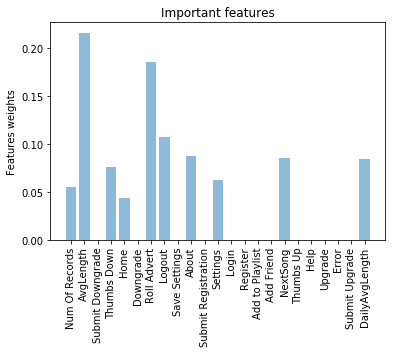

In [59]:
plot_important_features(fitted_model, df_features)

### Model 2 testing and reporting

Using Random Forest Classifier.

In [60]:
model = RandomForestClassifier(labelCol="label", featuresCol="features")
params = ParamGridBuilder().addGrid(model.maxDepth, [2, 5, 10]).addGrid(model.numTrees, [5, 10]).build()
fitted_model = fit_model(model, params, Train)

In [61]:
accuracy, precision, recall, f1score = pred_scoring(fitted_model, Train)
print("Score of Training data:\nAccurarcy: {0:.2f}\nPrecision: {0:.2f}\nRecall :{0:.2f}\nF1 score: {0:.2f}".format(accuracy, precision, recall, f1score))

Score of Training data:
Accurarcy: 0.97
Precision: 0.97
Recall :0.97
F1 score: 0.97


In [64]:
accuracy, precision, recall, f1score = pred_scoring(fitted_model, Test)
print("Score of Testing data:\nAccurarcy: {0:.2f}\nPrecision: {0:.2f}\nRecall :{0:.2f}\nF1 score: {0:.2f}".format(accuracy, precision, recall, f1score))

Score of Testing data:
Accurarcy: 0.68
Precision: 0.68
Recall :0.68
F1 score: 0.68


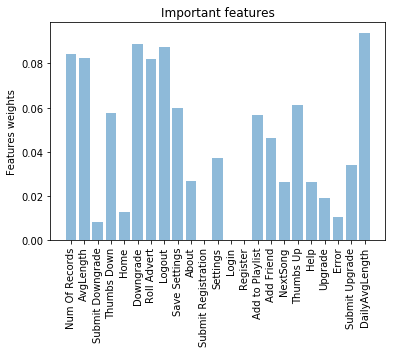

In [65]:
plot_important_features(fitted_model, df_features)

### Model 3 testing and reporting

Using Gradient-Boosted Tree classifier.

In [66]:
model = GBTClassifier(labelCol="label", featuresCol="features")
params = ParamGridBuilder().addGrid(model.maxDepth, [2, 5, 10]).addGrid(model.maxIter, [5, 10]).build()
fitted_model = fit_model(model, params, Train)

In [67]:
accuracy, precision, recall, f1score = pred_scoring(fitted_model, Train)
print("Score of Training data:\nAccurarcy: {0:.2f}\nPrecision: {0:.2f}\nRecall :{0:.2f}\nF1 score: {0:.2f}".format(accuracy, precision, recall, f1score))

Score of Training data:
Accurarcy: 0.79
Precision: 0.79
Recall :0.79
F1 score: 0.79


In [70]:
accuracy, precision, recall, f1score = pred_scoring(fitted_model, Test)
print("Score of Testing data:\nAccurarcy: {0:.2f}\nPrecision: {0:.2f}\nRecall :{0:.2f}\nF1 score: {0:.2f}".format(accuracy, precision, recall, f1score))

Score of Testing data:
Accurarcy: 0.71
Precision: 0.71
Recall :0.71
F1 score: 0.71


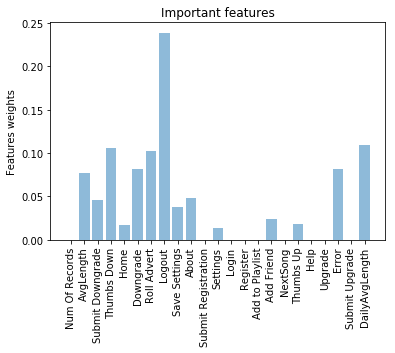

In [71]:
plot_important_features(fitted_model, df_features)

# Conclusion

- Of the three models tested, we found Gradient-Boosted Tree has best overall scoring, achieving F1 scores of 0.79 on training and 0.71 for testing. Decision Tree and Random Forest both achieved very high training score and a bit subpar testing score of 0.69 for both models.
- The most important features of the best performing model, Gradient-Boosted Tree, are:
  1. Logout: This is certainly surprising. Why logging out lead to high churn rate. It might be explained that when user deliberately logout of service, when most users usually just close browser out of convenience, is an indication that user might feel negatively about the service. Although the reason is unknown, this gives us good early warning.
  2. Daily Averge Length: This is what we expected in the initial analysis, the more time user spent on the service, is an indiciation stickness of user to the service.
  3. Thumbs Down: Like Logout, this could be an indication that user has negative reaction to the service.
  
In addition to provide prediction of churn, the important features analysis give additional insight to look for earning warning that user might not be happy about the service, and could be analyed further, to help improve the service to reduce churn rate.
  
## Improvments
- When performing EDA, we did not have deep semantics understanding about the action user take. If this information can be obtained, we will further filter out irrevalent actions. And re-fit the models.
- Further grid search on more parameters could be possible to enhance the models.
- This mini dataset have only 225 unique users to analyze the train data against. If more data can be obtained, it will certainly increase the fitness of the models.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# References

1. [Handling Missing Values in Spark](https://www.coursera.org/lecture/big-data-machine-learning/handling-missing-values-in-spark-Goh1z)
2. [Count the number of missing values in a dataframe Spark](https://stackoverflow.com/questions/44413132/count-the-number-of-missing-values-in-a-dataframe-spark)
3. [Convert rows into Dictionary in pyspark](https://stackoverflow.com/questions/49432167/convert-rows-into-dictionary-in-pyspark)
4. [aggregate function Count usage with groupBy in Spark](https://stackoverflow.com/questions/41890485/aggregate-function-count-usage-with-groupby-in-spark/41890813)
5. [how to get unique values of a column in pyspark dataframe](https://forums.databricks.com/questions/9655/how-to-get-unique-values-of-a-column-in-pyspark-da.html)
6. [pyspark.sql module](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)
7. [Parsing epoch milliseconds from json with Spark 2](https://stackoverflow.com/questions/44314199/parsing-epoch-milliseconds-from-json-with-spark-2)
8. [Spark dataframe: collect () vs select ()](https://stackoverflow.com/questions/44174747/spark-dataframe-collect-vs-select)
9. [Spark ML Tuning: model selection and hyperparameter tuning](https://spark.apache.org/docs/latest/ml-tuning.html)
10. [Spark Classification and regression](https://spark.apache.org/docs/latest/ml-classification-regression.html)
11. [Spark Extracting, transforming and selecting features](https://spark.apache.org/docs/latest/ml-features.html#vectorassembler)
12. [How to split columns into label and features in pyspark?](https://stackoverflow.com/questions/54662701/how-to-split-columns-into-label-and-features-in-pyspark)
13. [Spark Evaluation Metrics - RDD-based API](https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html)

